2. PHẦN MÔ HÌNH TRỘN GAUSSIAN (GAUSSIAN MIXTURE
MODEL)

In [1]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors

    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))

    # def e_step(self):
    #     '''
    #     E-step of EM algorithm.
    #     '''
    #     for i in range(self.k):
    #         self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
    #     self.z /= self.z.sum(axis=1, keepdims=True)

    # def m_step(self):
    #     '''
    #     M-step of EM algorithm.
    #     '''
    #     sum_z = self.z.sum(axis=0)
    #     self.pi = sum_z / self.num_points
    #     self.mu = np.matmul(self.z.T, self.data)
    #     self.mu /= sum_z[:, None]
    #     for i in range(self.k):
    #         j = np.expand_dims(self.data, axis=1) - self.mu[i]
    #         s = np.matmul(j.transpose([0, 2, 1]), j)
    #         self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
    #         self.sigma[i] /= sum_z[i]

    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            # Adding regularization to the covariance matrix to ensure it's positive definite
            cov = self.sigma[i] + np.eye(self.sigma[i].shape[0]) * 1e-6
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=cov, allow_singular=True)
        self.z /= self.z.sum(axis=1, keepdims=True)

    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            # Adding regularization to the covariance matrix to ensure it's positive definite
            self.sigma[i] += np.eye(self.sigma[i].shape[0]) * 1e-6

    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                cov = self.sigma[i] + np.eye(self.sigma[i].shape[0]) * 1e-6  # Stabilize covariance
                tot += self.pi[i] * multivariate_normal.pdf(
                    d, mean=self.mu[i], cov=cov, allow_singular=True
                )
            ll.append(np.log(tot))
        return np.sum(ll)


    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [3]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True)
    return x
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))

    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

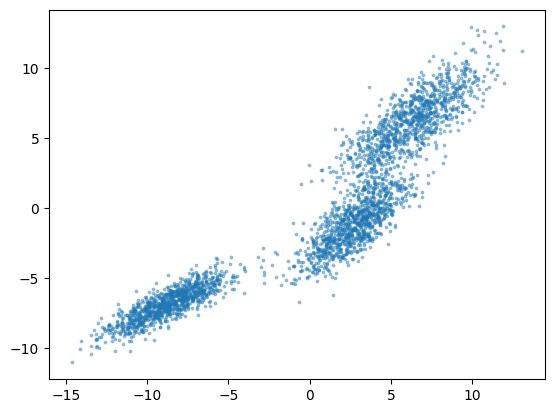

In [4]:
# Generate random 2D data with 3 clusters
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [5]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 2)

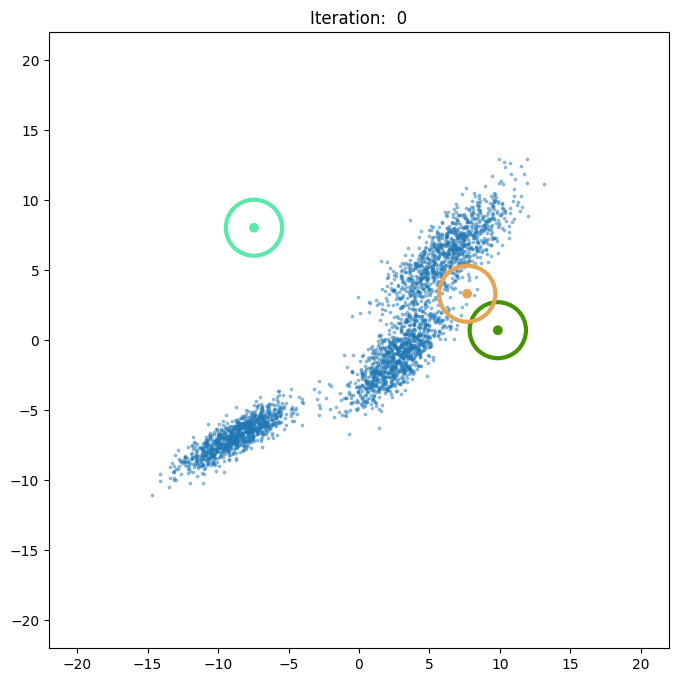

Iteration: 1, log-likelihood: -14006.8965


<Figure size 640x480 with 0 Axes>

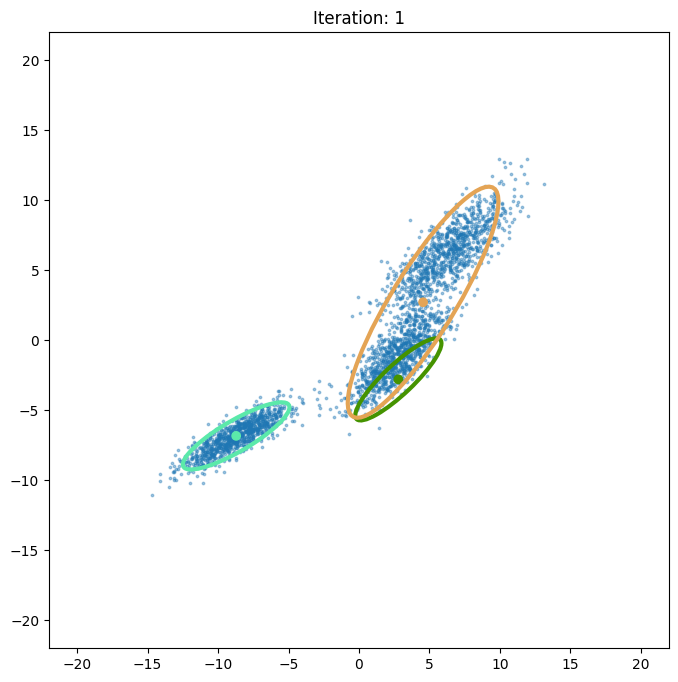

Iteration: 2, log-likelihood: -13979.0505


<Figure size 640x480 with 0 Axes>

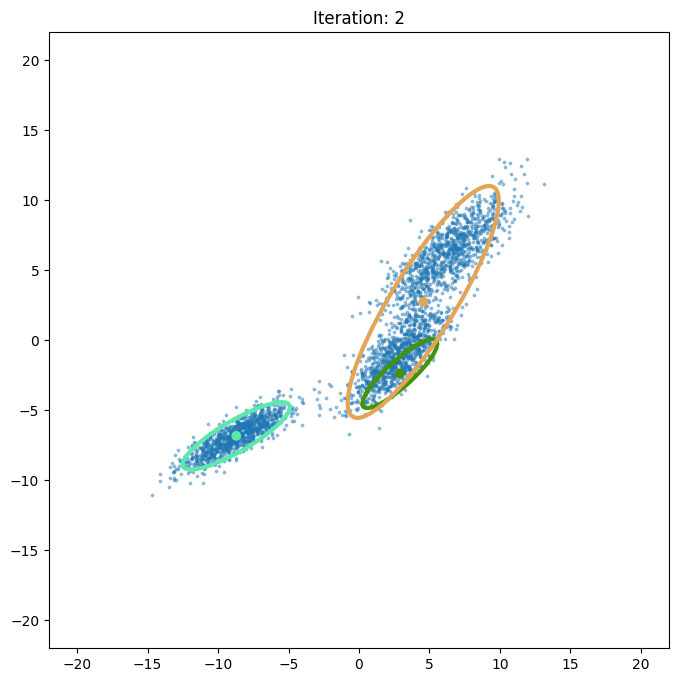

Iteration: 3, log-likelihood: -13956.1285


<Figure size 640x480 with 0 Axes>

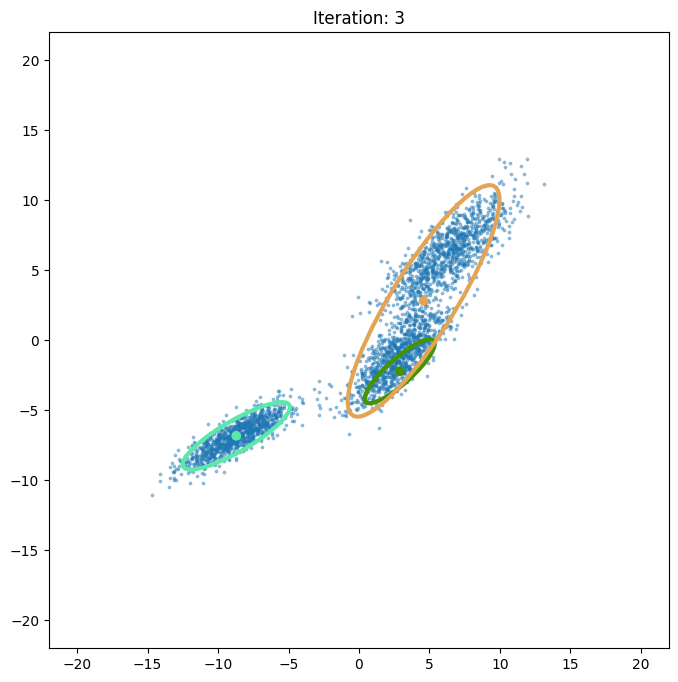

Iteration: 4, log-likelihood: -13933.2117


<Figure size 640x480 with 0 Axes>

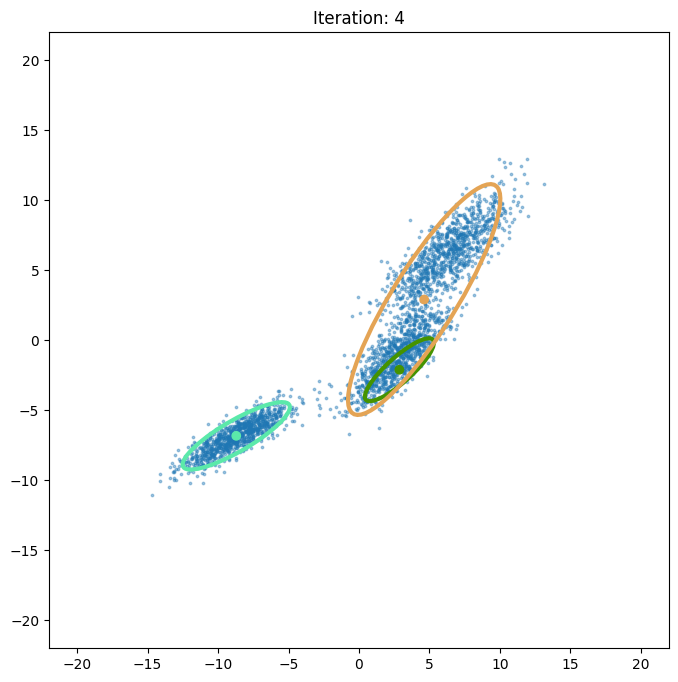

Iteration: 5, log-likelihood: -13909.4791


<Figure size 640x480 with 0 Axes>

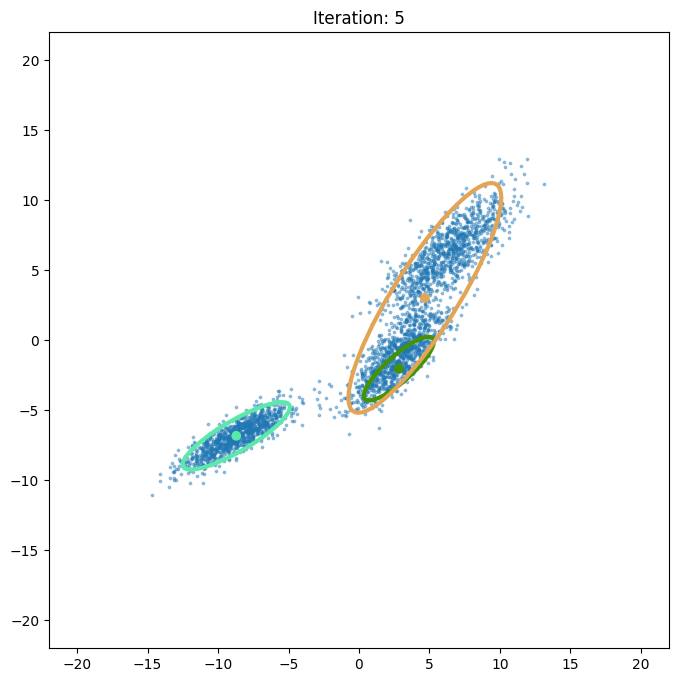

Iteration: 6, log-likelihood: -13885.0864


<Figure size 640x480 with 0 Axes>

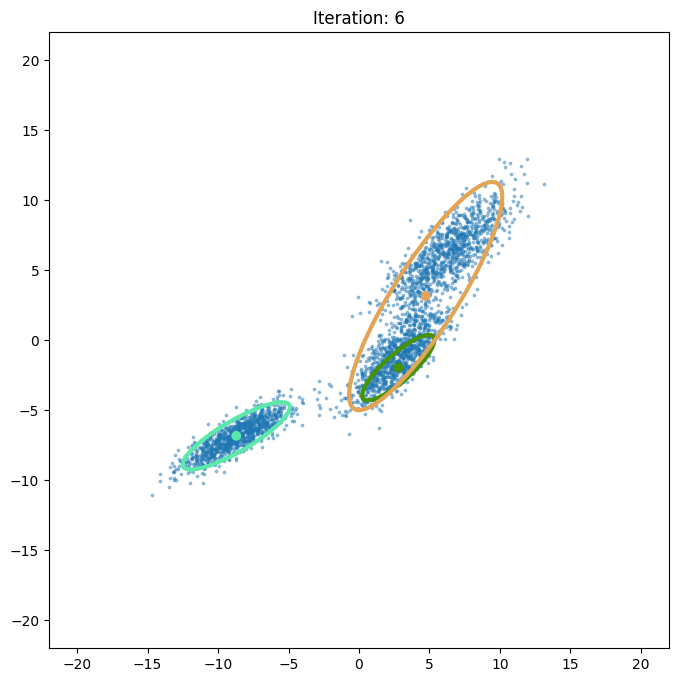

Iteration: 7, log-likelihood: -13860.8465


<Figure size 640x480 with 0 Axes>

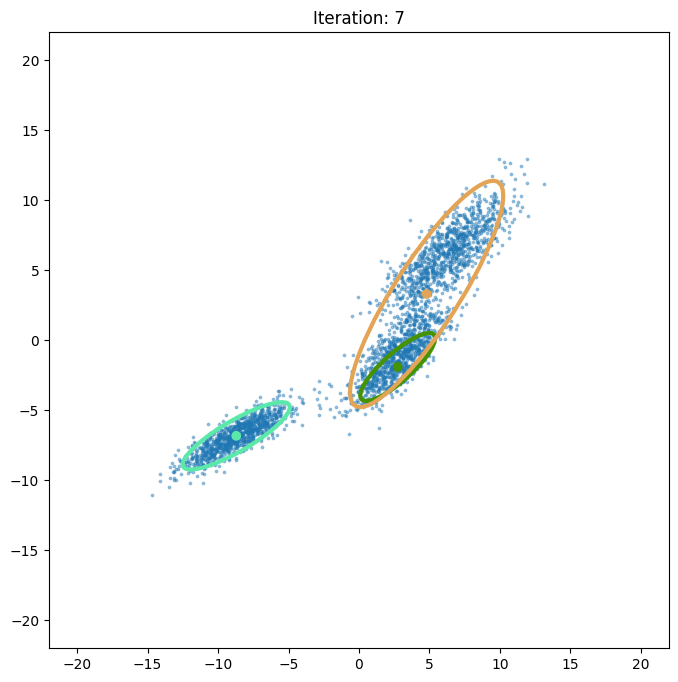

Iteration: 8, log-likelihood: -13837.7343


<Figure size 640x480 with 0 Axes>

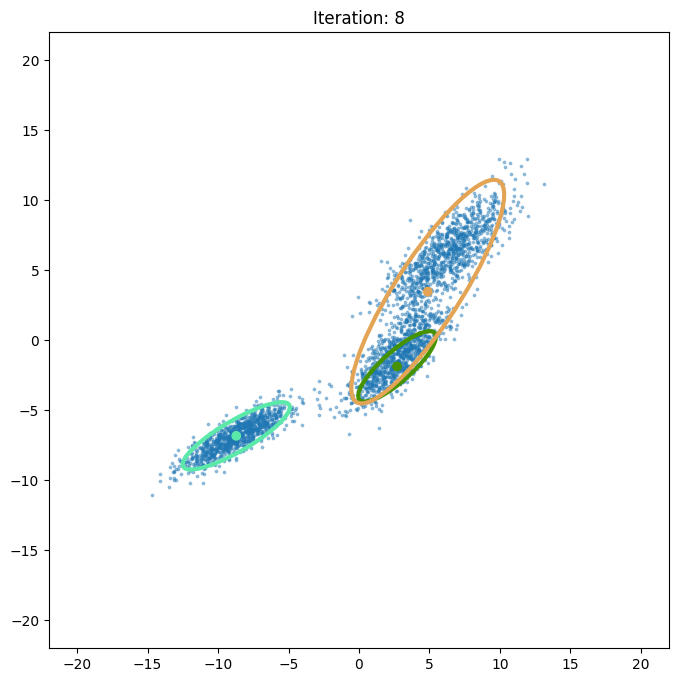

Iteration: 9, log-likelihood: -13816.4366


<Figure size 640x480 with 0 Axes>

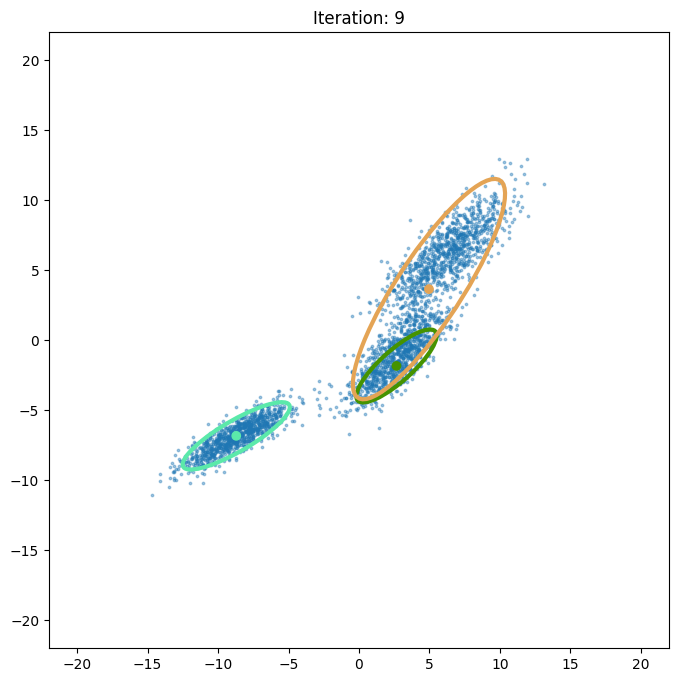

Iteration: 10, log-likelihood: -13797.1461


<Figure size 640x480 with 0 Axes>

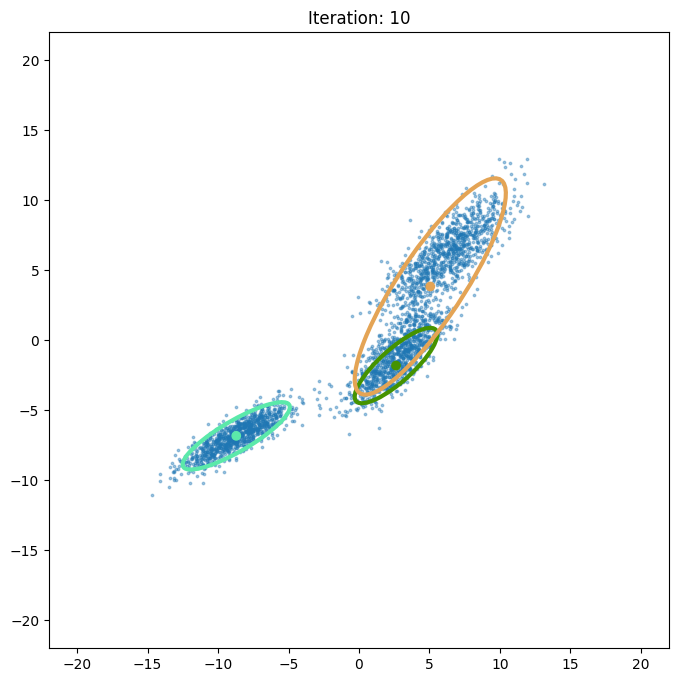

Iteration: 11, log-likelihood: -13779.6325


<Figure size 640x480 with 0 Axes>

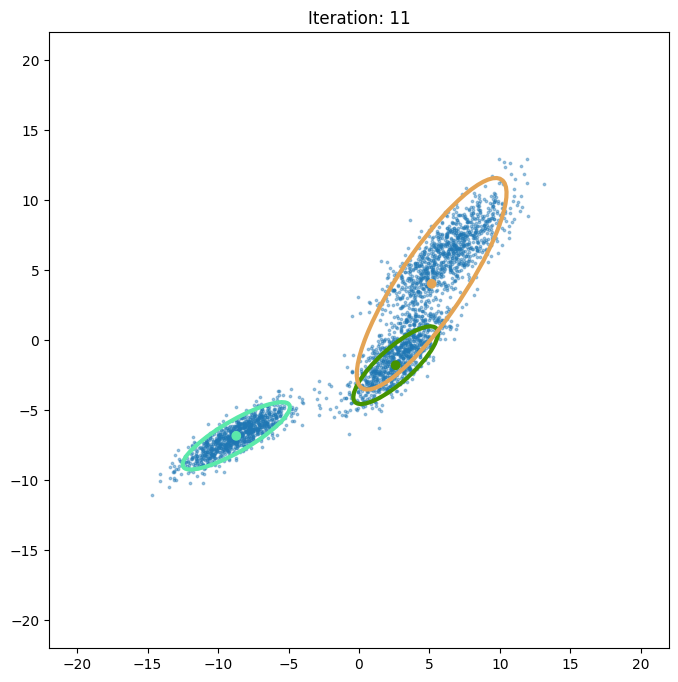

Iteration: 12, log-likelihood: -13763.4262


<Figure size 640x480 with 0 Axes>

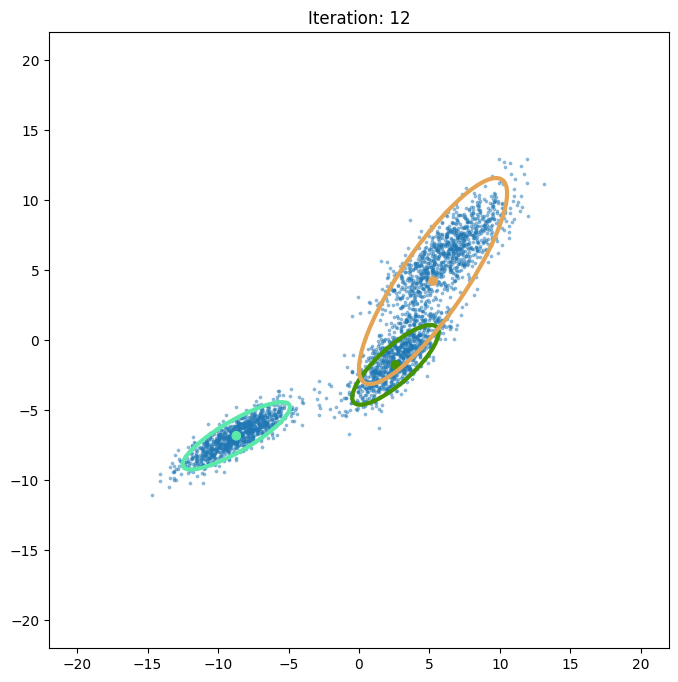

Iteration: 13, log-likelihood: -13747.9677


<Figure size 640x480 with 0 Axes>

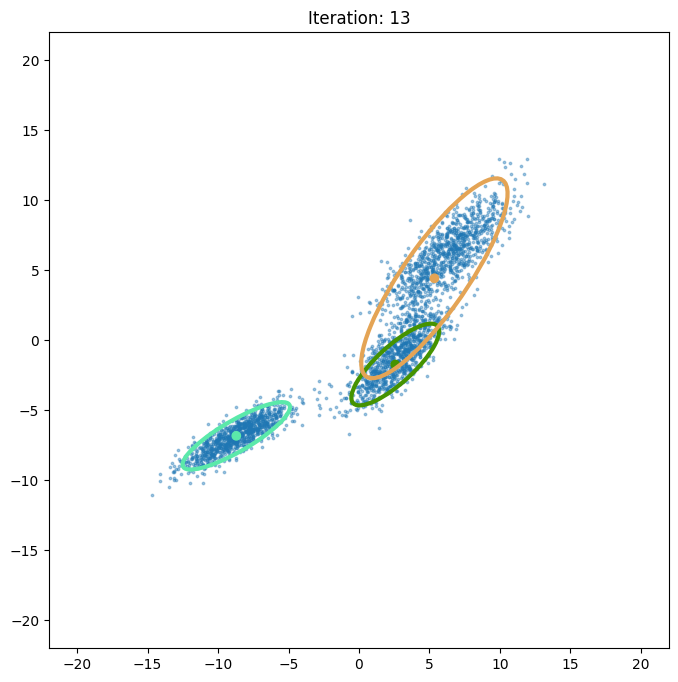

Iteration: 14, log-likelihood: -13732.6706


<Figure size 640x480 with 0 Axes>

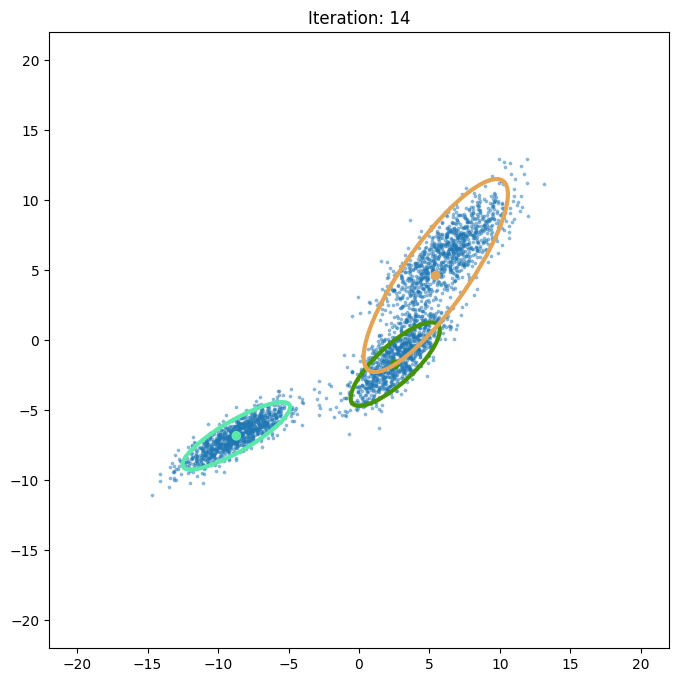

Iteration: 15, log-likelihood: -13716.9324


<Figure size 640x480 with 0 Axes>

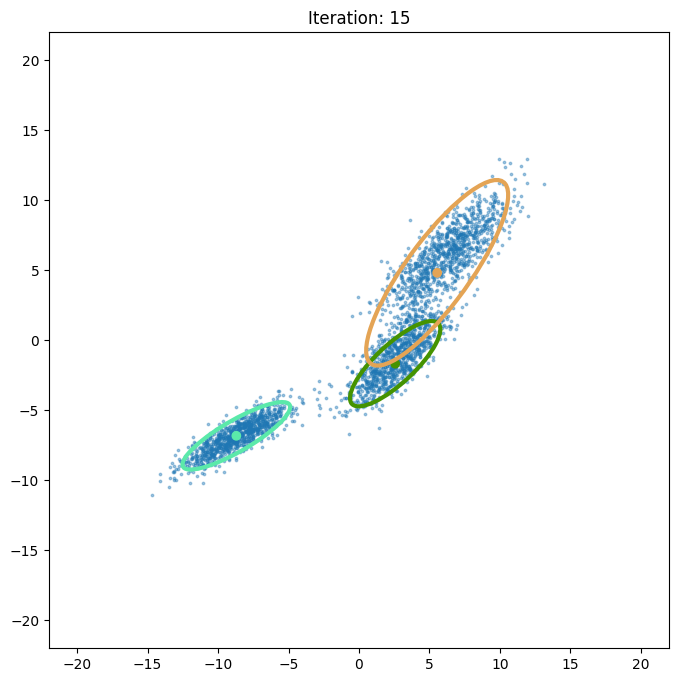

Iteration: 16, log-likelihood: -13700.2364


<Figure size 640x480 with 0 Axes>

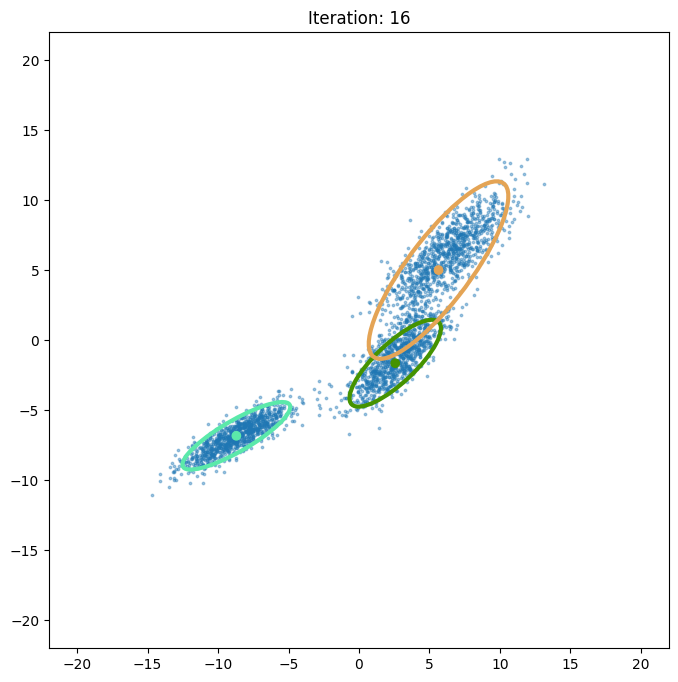

Iteration: 17, log-likelihood: -13682.5963


<Figure size 640x480 with 0 Axes>

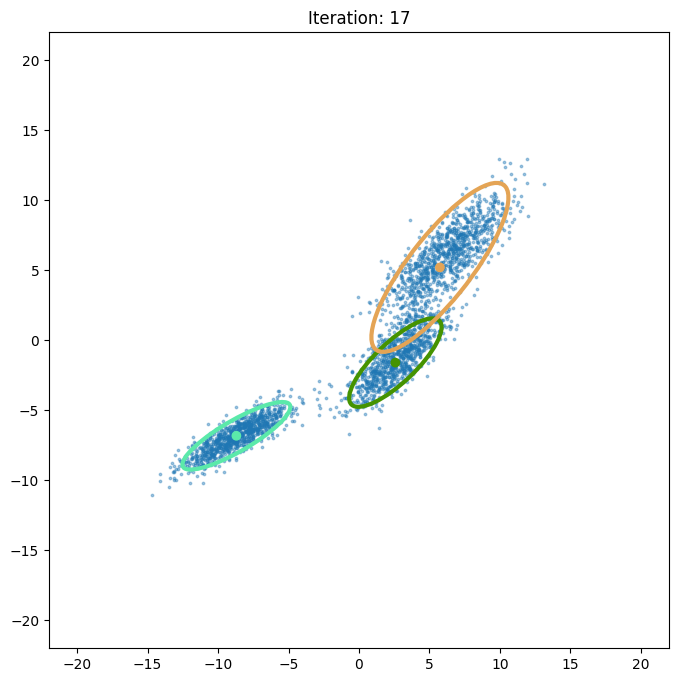

Iteration: 18, log-likelihood: -13664.8735


<Figure size 640x480 with 0 Axes>

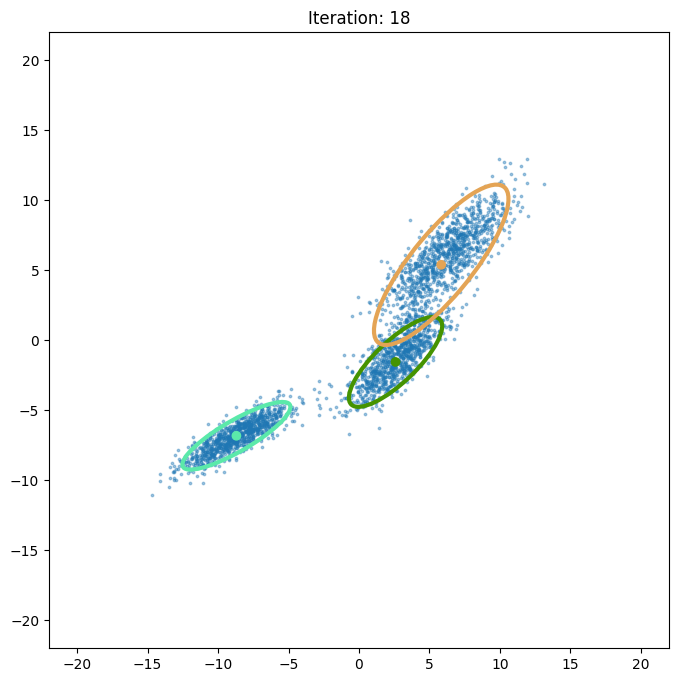

Iteration: 19, log-likelihood: -13648.3400


<Figure size 640x480 with 0 Axes>

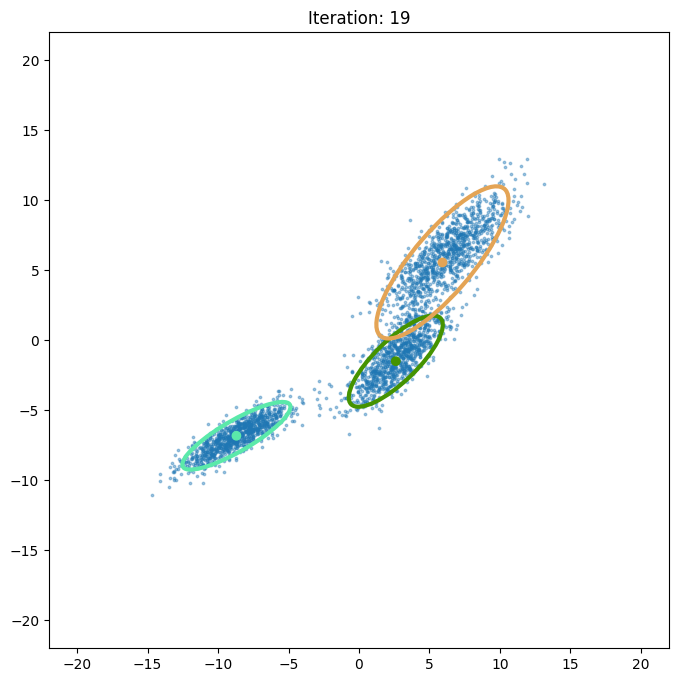

Iteration: 20, log-likelihood: -13634.2326


<Figure size 640x480 with 0 Axes>

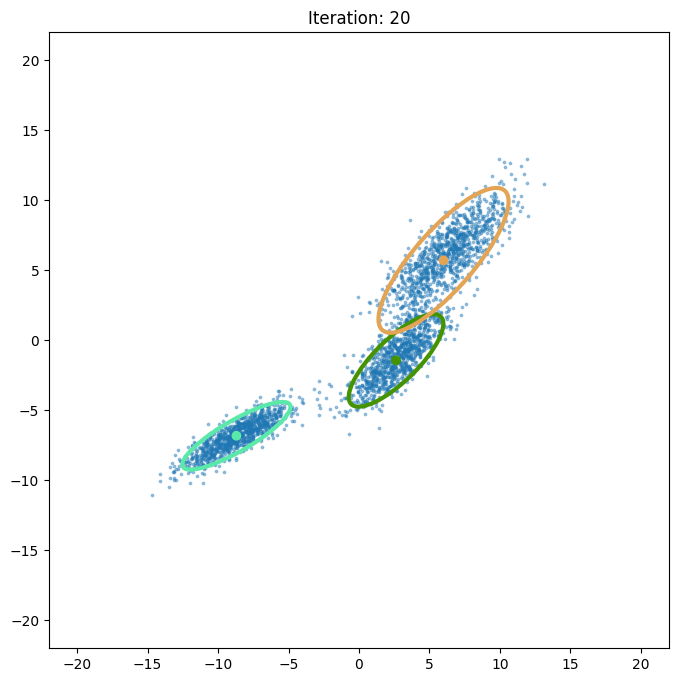

<Figure size 640x480 with 0 Axes>

In [6]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))

####Bài tập tự thực hành 1

In [7]:
from sklearn import datasets
import pandas as pd

# Load the Iris dataset
iris = datasets.load_iris()

# Create a Pandas DataFrame with the Iris data (excluding the target variable)
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Convert the DataFrame to a NumPy array for use in the GMM
X = iris_df.values

In [8]:
# Create a Gaussian Mixture Model with 3 clusters (same as the number of Iris species)
gmm = GMM(3, 4)  # 4 dimensions for the 4 features of Iris data

# Initialize EM algorithm with the Iris data
gmm.init_em(X)

# Train the GMM for a specified number of iterations
num_iters = 20
for e in range(num_iters):
    gmm.e_step()
    gmm.m_step()
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, gmm.log_likelihood(X)))

# Get the predicted cluster assignments for each data point
predicted_labels = np.argmax(gmm.z, axis=1)

# Get the true labels (species) from the Iris dataset
true_labels = iris.target

# Compare the predicted and true labels
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels)
confusion_mat = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_mat)

Iteration: 1, log-likelihood: -214.3548
Iteration: 2, log-likelihood: -214.3547
Iteration: 3, log-likelihood: -214.3547
Iteration: 4, log-likelihood: -207.2678
Iteration: 5, log-likelihood: -192.2978
Iteration: 6, log-likelihood: -192.2978
Iteration: 7, log-likelihood: -192.2978
Iteration: 8, log-likelihood: -192.2978
Iteration: 9, log-likelihood: -192.2978
Iteration: 10, log-likelihood: -192.2978
Iteration: 11, log-likelihood: -192.2978
Iteration: 12, log-likelihood: -192.2978
Iteration: 13, log-likelihood: -192.2978
Iteration: 14, log-likelihood: -192.2978
Iteration: 15, log-likelihood: -192.2978
Iteration: 16, log-likelihood: -192.2978
Iteration: 17, log-likelihood: -192.2978
Iteration: 18, log-likelihood: -192.2978
Iteration: 19, log-likelihood: -192.2978
Iteration: 20, log-likelihood: -192.2978
Accuracy: 0.0
Confusion Matrix:
 [[ 0  1 49]
 [50  0  0]
 [50  0  0]]


####Bài tập tự thực hành 2

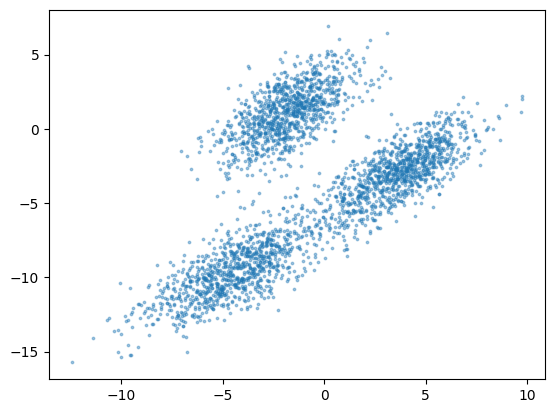

In [9]:
# Sử dụng hàm gen_data đã có để tạo dữ liệu
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [10]:
from sklearn.cluster import KMeans

# Khởi tạo mô hình KMeans với 3 cụm
kmeans = KMeans(n_clusters=3)

# Phân cụm dữ liệu
kmeans.fit(X)

# Lấy nhãn cụm dự đoán
predicted_labels_kmeans = kmeans.labels_

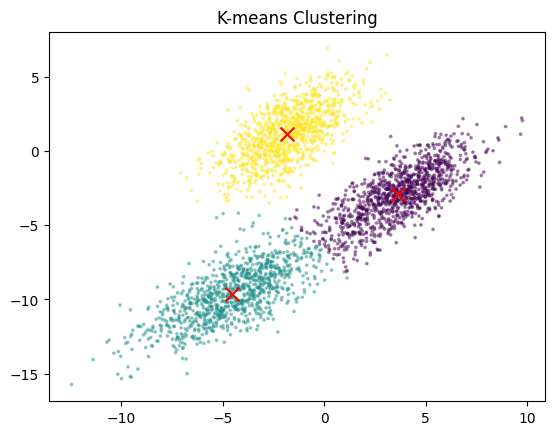

In [11]:
import matplotlib.pyplot as plt

# Vẽ dữ liệu và tâm cụm
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels_kmeans, s=3, alpha=0.4)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, c='red')
plt.title('K-means Clustering')
plt.show()

##Ví dụ 2

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
# Thư viện chứa model Gaussian Mixture

In [14]:
data = pd.read_csv("/content/shopping-data.csv",header=0,index_col=0)

print(data.shape)
data.head()
# Lấy ra thu nhập va điểm shopping
X = data.iloc[:, 2:4].values
# Chuẩn hoá dữ liệu
std = MinMaxScaler()
X_std = std.fit_transform(X)
print(X_std.shape)

# Khởi tạo đối tượng mô hình GaussianMixture
gm = GaussianMixture(n_components=5,
covariance_type='full',
random_state=0)

gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

(200, 4)
(200, 2)
means: 
 [[0.33368985 0.49394756]
 [0.60502531 0.15433196]
 [0.58393969 0.82673863]
 [0.09861098 0.21597752]
 [0.0829305  0.80743088]]
covariances: 
  [[[ 0.00613567 -0.00231927]
  [-0.00231927  0.0051635 ]]

 [[ 0.01818446  0.00433814]
  [ 0.00433814  0.00873064]]

 [[ 0.01808598 -0.00031096]
  [-0.00031096  0.0091568 ]]

 [[ 0.00453005  0.00255303]
  [ 0.00255303  0.01918353]]

 [[ 0.00337483 -0.0001437 ]
  [-0.0001437   0.01026088]]]


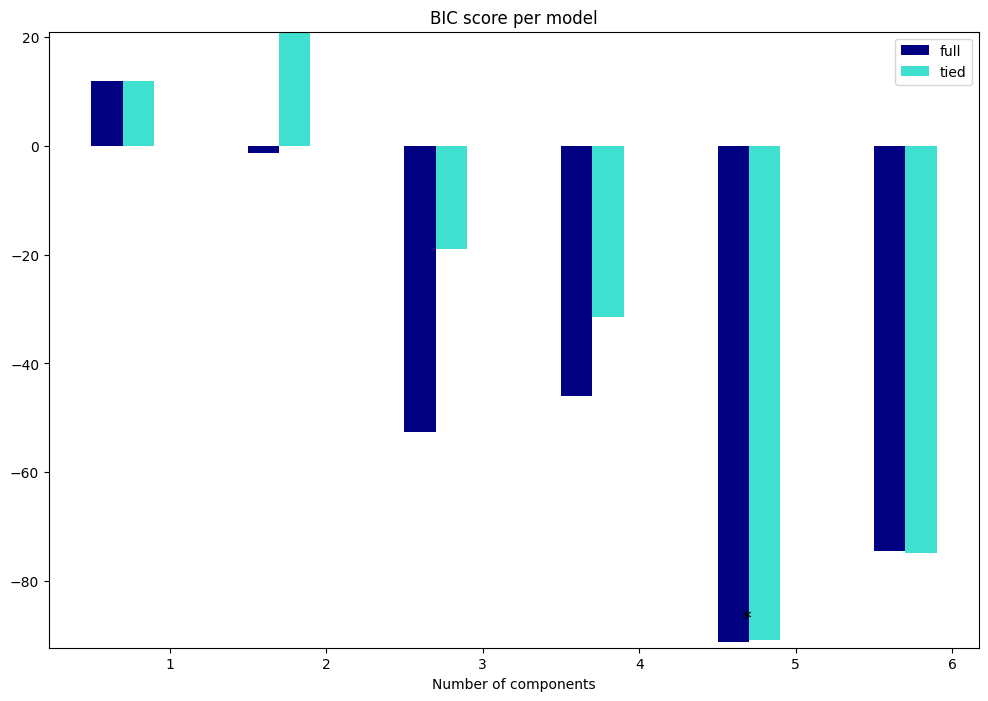

In [15]:
lowest_bic = np.inf
bic = []
n_components_range = range(1, 7)
cv_types = ['full', 'tied']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit Gaussian mixture theo phương pháp huấn luyện EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))

        # Gán model có BIC score thấp nhất là model tốt nhất
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []

# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range):(i + 1) * len(n_components_range)],
            width=.2,
            color=color
        )
    )

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = (
    np.mod(bic.argmin(), len(n_components_range)) + 0.65 +
    0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), '*', fontsize=14)

plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)
plt.show()

In [16]:
def _plot_kmean_scatter(X, labels):
  '''
  X: dữ liệu đầu vào
  labels: nhãn dự báo
  '''
  # lựa chọn màu sắc
  num_classes = len(np.unique(labels))
  palette = np.array(sns.color_palette("hls", num_classes))
  # vẽ biểu đồ scatter
  fig = plt.figure(figsize=(12, 8))
  ax = plt.subplot()
  sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40,

  c=palette[labels.astype(int)])

  # thêm nhãn cho mỗi cluster
  txts = []
  for i in range(num_classes):
  # Vẽ text tên cụm tại trung vị của mỗi cụm
    xtext, ytext = np.median(X[labels == i, :], axis=0)
    txt = ax.text(xtext, ytext, str(i), fontsize=24)

    txt.set_path_effects([
      PathEffects.Stroke(linewidth=5, foreground="w"),
      PathEffects.Normal()])
    txts.append(txt)
  plt.title('t-sne visualization')

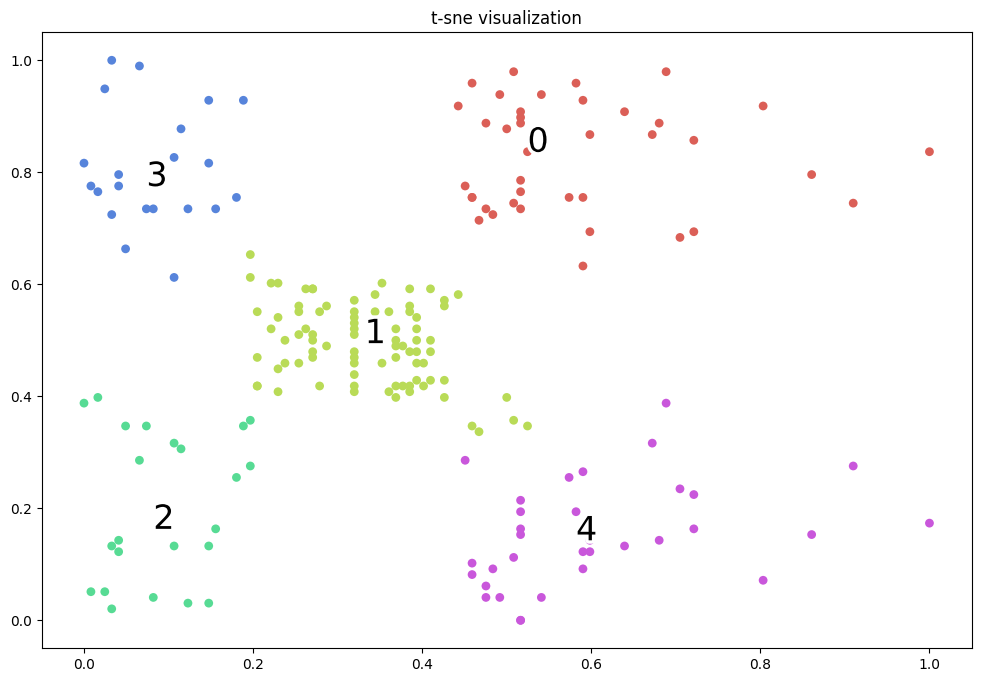

In [17]:
labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)

##Ví dụ mở rộng

In [18]:
import pandas as pd

# Nạp dữ liệu từ file CSV
data = pd.read_csv("/content/Sales_Transactions_Dataset_Weekly (1).csv")

# Lựa chọn đặc trưng (lượng giao dịch theo tuần hoặc chuẩn hóa)
# Giả sử ta chọn lượng giao dịch theo tuần (week 0 - week 51)
X = data.iloc[:, 1:53].values  # Lấy dữ liệu từ cột week 0 đến week 51

In [19]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Khoảng số cụm cần kiểm tra
n_components_range = range(5, 16)

# Lưu trữ BIC score cho mỗi số cụm
bic_scores = []

# Tìm số cụm tối ưu bằng BIC score
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))

# Số cụm tối ưu tương ứng với BIC score thấp nhất
optimal_n_clusters = n_components_range[np.argmin(bic_scores)]

print(f"Số cụm tối ưu: {optimal_n_clusters}")

Số cụm tối ưu: 9


In [20]:
# Khởi tạo mô hình phân cụm (GMM hoặc K-means) với số cụm tối ưu
# Ví dụ sử dụng GMM:
gmm = GaussianMixture(n_components=optimal_n_clusters, covariance_type='full')

# Huấn luyện mô hình
gmm.fit(X)

# Dự đoán nhãn cụm cho từng mã sản phẩm
cluster_labels = gmm.predict(X)

# Thêm nhãn cụm vào DataFrame
data['cluster'] = cluster_labels

print(data.head())  # Xem kết quả

  Product_Code  W0  W1  W2  W3  W4  W5  W6  W7  W8  ...  Normalized 43  \
0           P1  11  12  10   8  13  12  14  21   6  ...           0.22   
1           P2   7   6   3   2   7   1   6   3   3  ...           0.40   
2           P3   7  11   8   9  10   8   7  13  12  ...           1.00   
3           P4  12   8  13   5   9   6   9  13  13  ...           0.47   
4           P5   8   5  13  11   6   7   9  14   9  ...           0.53   

   Normalized 44  Normalized 45  Normalized 46  Normalized 47  Normalized 48  \
0           0.28           0.39           0.50           0.00           0.22   
1           0.50           0.10           0.10           0.40           0.50   
2           0.18           0.18           0.36           0.45           1.00   
3           0.06           0.12           0.24           0.35           0.71   
4           0.27           0.60           0.20           0.20           0.13   

   Normalized 49  Normalized 50  Normalized 51  cluster  
0           0.17